#### Quiero hacer unos randoms que tengan el gradiente en DEC que tienen los rayos cosmicos

In [1]:
def generate_RandomCatalogue_with_CRgradient(N, nmult, dec_max, cr_ra, cr_dec,
                                             seed=None, milkyway_mask=True,
                                             deflection=None,
                                             deflection_file='../data/JF12_GMFdeflection_Z1_E10EeV.csv'):
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    from scipy.stats import binned_statistic_2d

    if seed is not None:
        np.random.seed(seed)

    # Bin cosmic ray density on the sky
    nbins = 60  # resolution of density map (adjust if needed)
    H, xedges, yedges, _ = binned_statistic_2d(
        cr_ra, cr_dec, None, statistic='count',
        bins=[np.linspace(0, 360, nbins+1), np.linspace(-90, dec_max, nbins+1)]
    )
    H = H.T  # So rows = Dec, cols = RA

    # Normalize and flatten for probability sampling
    H = np.nan_to_num(H)
    H += 1e-6  # to avoid zero-probability regions
    H /= H.sum()  # normalize to make it a probability map

    # Generate large pool of randoms
    ra_pool = np.random.uniform(0, 360, N * nmult * 100)
    sin_dec_pool = np.random.uniform(np.sin(np.radians(-90)), np.sin(np.radians(dec_max)), N * nmult * 100)
    dec_pool = np.degrees(np.arcsin(sin_dec_pool))

    # Apply Milky Way mask
    if milkyway_mask:
        coords = SkyCoord(ra_pool, dec_pool, frame='icrs', unit='degree')
        mask = np.abs(coords.galactic.b.deg) > 5.
        ra_pool, dec_pool = ra_pool[mask], dec_pool[mask]

    # Apply deflection mask
    if deflection in ['low', 'high']:
        randoms = np.column_stack((ra_pool, dec_pool))
        deflection_mask = apply_deflection_mask(deflection_file, randoms[:, 0], randoms[:, 1], deflection)
        randoms = randoms[deflection_mask]
        ra_pool, dec_pool = randoms[:, 0], randoms[:, 1]

    # Rejection sampling based on CR density
    ra_idx = np.searchsorted(xedges, ra_pool, side='right') - 1
    dec_idx = np.searchsorted(yedges, dec_pool, side='right') - 1

    valid = (ra_idx >= 0) & (ra_idx < nbins) & (dec_idx >= 0) & (dec_idx < nbins)
    ra_pool, dec_pool, ra_idx, dec_idx = ra_pool[valid], dec_pool[valid], ra_idx[valid], dec_idx[valid]

    probs = H[dec_idx, ra_idx]
    probs /= probs.max()  # normalize to [0, 1] for rejection sampling

    accept = np.random.uniform(0, 1, size=probs.size) < probs
    ra_selected = ra_pool[accept]
    dec_selected = dec_pool[accept]

    # Final cut to desired size
    if ra_selected.size < N * nmult:
        raise RuntimeError("Not enough randoms passed the rejection sampling. Increase pool size or relax mask.")
    
    return ra_selected[:N*nmult], dec_selected[:N*nmult]




In [2]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
events_a8 = events_a8[mask_eve]
#mask_eve = np.where(events_a8['dec']< 0.)[0]
#events_a8 = events_a8[mask_eve]

cr_ra = events_a8['RA']
cr_dec = events_a8['dec']

randoms = generate_RandomCatalogue_with_CRgradient(N=len(cr_ra), nmult=10, cr_ra=cr_ra, cr_dec=cr_dec, dec_max=45)

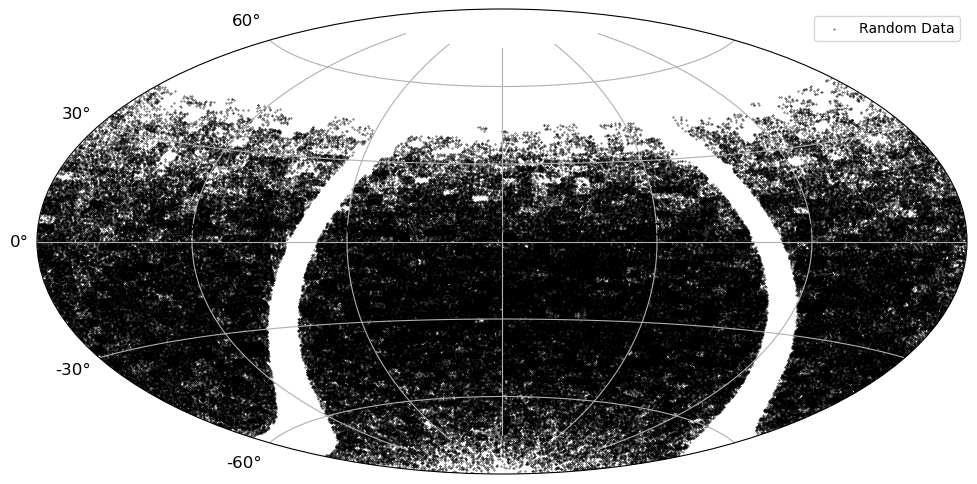

In [3]:
def format_axes(ax):
    """Format axes with RA in hours and Dec in degrees."""
    xticks_deg = [-120, -60, 0, 60, 120]
    xticks_rad = np.radians(xticks_deg)
    ax.set_xticks(xticks_rad)
    ax.set_xticklabels([f'{int(deg)}°' for deg in xticks_deg])
    yticks_deg = [-60, -30, 0, 30, 60]
    yticks_rad = np.radians(yticks_deg)
    ax.set_yticks(yticks_rad)
    ax.set_yticklabels([f'{deg}°' for deg in yticks_deg])
    ax.tick_params(axis='both', which='major', labelsize=12)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.grid(True)

import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': 'aitoff'})        

# Ensure axs is always iterable
#axs = np.array(axs).reshape(-1)

#for q, ax in zip(range(params['nquant']),axs):
#    gxs_sc = SkyCoord(data[q]['_RAJ2000'],data[q]['_DEJ2000'],frame='icrs',unit='degree')

#    eve_sc = SkyCoord(events_a8['RA'],events_a8['dec'],frame='icrs',unit='degree')
ran_sc = SkyCoord(randoms[0], randoms[1],frame='icrs',unit='degree')

ax.scatter(ran_sc.ra.wrap_at(180*u.degree).to(u.rad),ran_sc.dec.to(u.rad),s=.1,c='k',label='Random Data')
#ax.scatter(eve_sc.ra.wrap_at(180*u.degree).to(u.rad),eve_sc.dec.to(u.rad),s=.1,label='UHECRs')
#ax.scatter(gxs_sc.ra.wrap_at(180*u.degree).to(u.rad),gxs_sc.dec.to(u.rad),s=5,c='C03',label='Galaxies')

ax.legend(loc=1,fontsize=10)
#ax.set_title(f'{quantiles[q]:.1f} '+r'< K_{abs} < '+f'{quantiles[q+1]:.1f}')
ax.grid(True)
format_axes(ax)

plt.show()

#### Empiezo de nuevo

In [4]:
import numpy as np
from astropy.io import ascii
from astropy.coordinates import SkyCoord
import astropy.units as u

events_a8 = ascii.read('../data/Auger/events_a8_lb.dat')
eve = SkyCoord(events_a8['RA'], events_a8['dec'], frame='icrs', unit='degree')
mask_eve = np.where(abs(eve.galactic.b) > 5. * u.degree)[0]
events_a8 = events_a8[mask_eve]
#mask_eve = np.where(events_a8['dec']< 0.)[0]
#events_a8 = events_a8[mask_eve]

cr_ra = events_a8['RA']
cr_dec = events_a8['dec']

In [ ]:
def generate_RandomCatalogue(N,nmult,dec_max,seed=None, milkyway_mask=True, deflection=None, deflection_file='../data/JF12_GMFdeflection_Z1_E10EeV.csv'):
    import numpy as np
    from astropy.coordinates import SkyCoord
    import astropy.units as u
    
    if seed!=None: np.random.seed(seed)

    ra_min = 0.
    ra_max = 360
    dec_min = -90.
    dec_max = dec_max

    rand_ra = np.random.uniform(ra_min, ra_max, N*nmult*100)
    rand_sindec = np.random.uniform(np.sin(dec_min*np.pi/180.), np.sin(dec_max*np.pi/180.), \
                                    N*nmult*100)
    rand_dec = np.arcsin(rand_sindec)*180./np.pi

    #Eliminates points within 5° in galactic latitude
    if milkyway_mask==True:
        ran = SkyCoord(rand_ra,rand_dec,frame='icrs',unit='degree')
        mask_ran = np.where([abs(ran.galactic.b)>5.*(u.degree)])[1]
        rand_ra = rand_ra[mask_ran]
        rand_dec = rand_dec[mask_ran]

    # If deflection region is specified, select accordingly
    if deflection == 'high' or deflection == 'low':
        randoms = np.column_stack((rand_ra, rand_dec))
        deflection_mask = apply_deflection_mask(deflection_file, randoms[:, 0], randoms[:, 1], deflection)
        randoms = randoms[deflection_mask]
        rand_ra = randoms[:, 0]
        rand_dec = randoms[:, 1]

    rand_ra_cut = rand_ra[:N*nmult]
    rand_dec_cut = rand_dec[:N*nmult]

    # Check if the size of the random catalogue matches the expected size
    if rand_ra_cut.size != N*nmult:
        raise ValueError(f"Random catalogue size mismatch: expected {N*nmult}, got {rand_ra_cut.size}")

    return rand_ra_cut, rand_dec_cut 

rand_ra, rand_dec = generate_RandomCatalogue(N=len(cr_ra), nmult=10, dec_max=45)

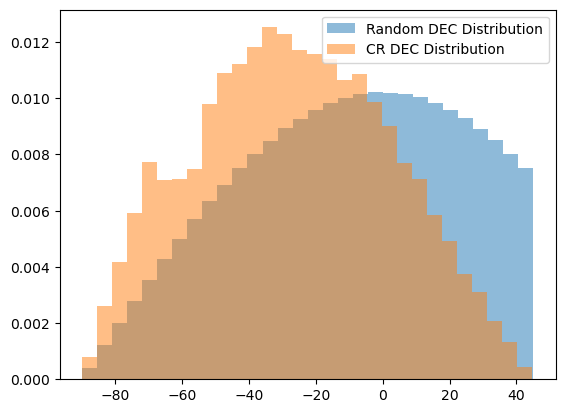

In [21]:
x = np.random.uniform(np.sin(-90*np.pi/180.), np.sin(45*np.pi/180.), \
                                    10000000)

plt.hist(np.arcsin(x)*180./np.pi, bins=30, alpha=0.5, label='Random DEC Distribution', density=True)
plt.hist(cr_dec, bins=30, alpha=0.5, label='CR DEC Distribution', density=True)
plt.legend()
plt.show()

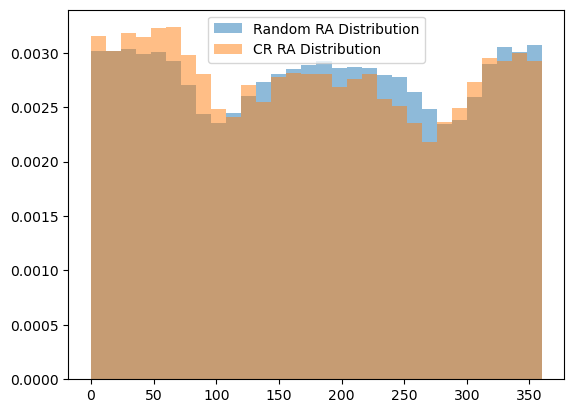

In [7]:
plt.hist(rand_ra, bins=30, alpha=0.5, label='Random RA Distribution', density=True)
plt.hist(cr_ra, bins=30, alpha=0.5, label='CR RA Distribution', density=True)
plt.legend()
plt.show()

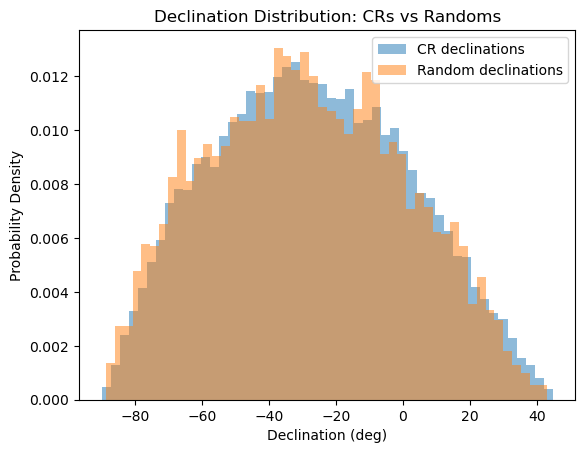

In [ ]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load CR data file with RA and dec columns
events = ascii.read('../data/Auger/events_a8_lb.dat')
dec_vals = events['dec']  # declination in degrees
ra_vals = events['RA']    # right ascension in degrees

# Step 1: Empirical declination distribution
hist, bin_edges = np.histogram(dec_vals, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Step 2: Construct inverse CDF
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]  # normalize to [0,1]
inv_cdf = interp1d(cdf, bin_centers, bounds_error=False, fill_value=(bin_centers[0], bin_centers[-1]))

# Step 3: Function to sample RA uniformly, Dec from declination PDF
def sample_random_CR_like(N):
    ra_rand = np.random.uniform(0, 360, N)
    u = np.random.uniform(0, 1, N)
    dec_rand = inv_cdf(u)
    return ra_rand, dec_rand

# Example usage
ra_random, dec_random = sample_random_CR_like(5000)

# Optional plot to verify declination distribution match
plt.hist(dec_random, bins=50, density=True, alpha=0.5, label='Random declinations')
plt.hist(dec_vals, bins=50, density=True, alpha=0.5, label='CR declinations')
plt.xlabel('Declination (deg)')
plt.ylabel('Probability Density')
plt.legend()
plt.title('Declination Distribution: CRs vs Randoms')
plt.show()


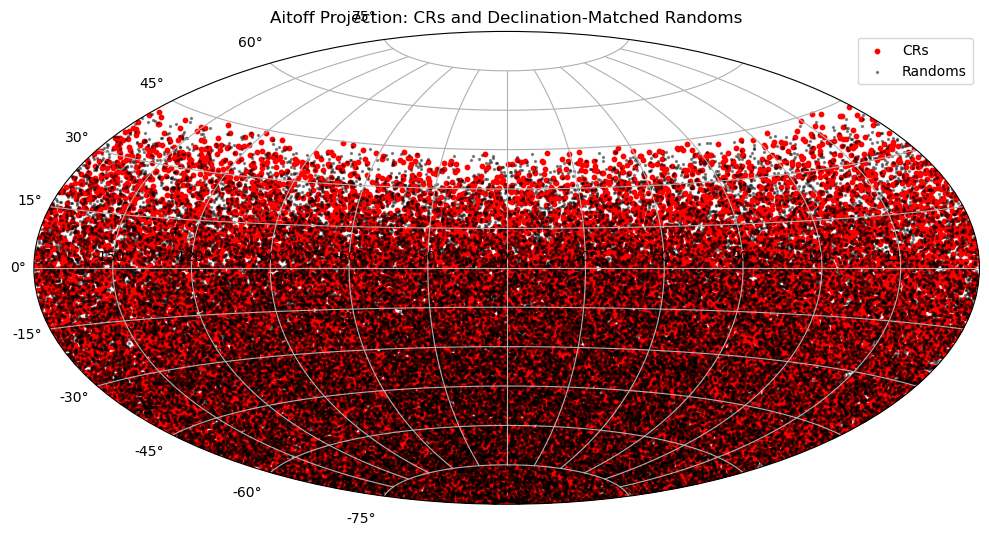

In [32]:
import numpy as np
from astropy.io import ascii
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load CR data (RA, dec in degrees)
events = ascii.read('../data/Auger/events_a8_lb.dat')
ra_vals = events['RA']
dec_vals = events['dec']

# Step 1: Build declination PDF
hist, bin_edges = np.histogram(dec_vals, bins=50, density=True)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
cdf = np.cumsum(hist)
cdf = cdf / cdf[-1]
inv_cdf = interp1d(cdf, bin_centers, bounds_error=False, fill_value=(bin_centers[0], bin_centers[-1]))

# Step 2: Generate randoms
def sample_random_CR_like(N):
    ra_rand = np.random.uniform(0, 360, N)
    u = np.random.uniform(0, 1, N)
    dec_rand = inv_cdf(u)
    return ra_rand, dec_rand

ra_rand, dec_rand = sample_random_CR_like(50000)

# Step 3: Aitoff plot
def to_radians_shifted(ra_deg, dec_deg):
    ra_rad = np.radians(ra_deg)
    dec_rad = np.radians(dec_deg)
    ra_rad = np.remainder(ra_rad + 2*np.pi, 2*np.pi)  # ensure [0, 2pi)
    ra_rad[ra_rad > np.pi] -= 2*np.pi  # shift to [-pi, pi]
    return ra_rad, dec_rad

ra_cr_rad, dec_cr_rad = to_radians_shifted(ra_vals, dec_vals)
ra_rand_rad, dec_rand_rad = to_radians_shifted(ra_rand, dec_rand)

plt.figure(figsize=(10, 6))
ax = plt.subplot(111, projection='aitoff')
ax.grid(True)


# Plot real CRs
ax.scatter(ra_cr_rad, dec_cr_rad, s=10, c='red', label='CRs')
# Plot randoms
ax.scatter(ra_rand_rad, dec_rand_rad, s=2, c='k', alpha=0.4, label='Randoms')



ax.legend(loc='upper right')
plt.title('Aitoff Projection: CRs and Declination-Matched Randoms')
plt.tight_layout()
plt.show()
